In [2]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


In [3]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

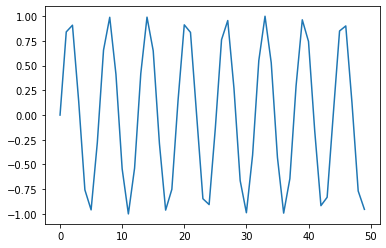

In [4]:
plt.plot(sin_wave[:50])

In [5]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [6]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [7]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

## Step 1: Create the Architecture for our RNN model
Our next task is defining all the necessary variables and functions we’ll use in the RNN model. Our model will take in the input sequence, process it through a hidden layer of 100 units, and produce a single valued output:

In [8]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

We will then define the weights of the network:

In [9]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

Here,

U is the weight matrix for weights between input and hidden layers
V is the weight matrix for weights between hidden and output layers
W is the weight matrix for shared weights in the RNN layer (hidden layer)
Finally, we will define the activation function, sigmoid, to be used in the hidden layer:

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Step 2: Train the Model
Now that we have defined our model, we can finally move on with training it on our sequence data. We can subdivide the training process into smaller steps, namely:

Step 2.1 : Check the loss on training data 

Step 2.1.1 : Forward Pass

Step 2.1.2 : Calculate Error

Step 2.2 : Check the loss on validation data

Step 2.2.1 : Forward Pass

Step 2.2.2 : Calculate Error

Step 2.3 : Start actual training

Step 2.3.1 : Forward Pass

Step 2.3.2 : Backpropagate Error

Step 2.3.3 : Update weights

We need to repeat these steps until convergence. If the model starts to overfit, stop! Or simply pre-define the number of epochs.

 

### Step 2.1: Check the loss on training data
We will do a forward pass through our RNN model and calculate the squared error for the predictions for all records in order to get the loss value.

In [16]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
       # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
    
     # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[115198.20663276]] , Val Loss:  [[57597.21226457]]
Epoch:  2 , Loss:  [[72203.77389597]] , Val Loss:  [[36100.38167024]]
Epoch:  3 , Loss:  [[39209.34115909]] , Val Loss:  [[19603.55107586]]
Epoch:  4 , Loss:  [[16214.90780059]] , Val Loss:  [[8106.72017058]]
Epoch:  5 , Loss:  [[3220.91284581]] , Val Loss:  [[1610.11167388]]
Epoch:  6 , Loss:  [[35.19827774]] , Val Loss:  [[17.56120113]]
Epoch:  7 , Loss:  [[23.43859117]] , Val Loss:  [[11.71220216]]
Epoch:  8 , Loss:  [[23.02648667]] , Val Loss:  [[11.50540029]]
Epoch:  9 , Loss:  [[22.88693901]] , Val Loss:  [[11.43446626]]
Epoch:  10 , Loss:  [[23.1824594]] , Val Loss:  [[11.58115369]]
Epoch:  11 , Loss:  [[22.54319894]] , Val Loss:  [[11.2633744]]
Epoch:  12 , Loss:  [[22.77550027]] , Val Loss:  [[11.38089096]]
Epoch:  13 , Loss:  [[22.79243498]] , Val Loss:  [[11.38884341]]
Epoch:  14 , Loss:  [[23.05314743]] , Val Loss:  [[11.51953904]]
Epoch:  15 , Loss:  [[23.38779183]] , Val Loss:  [[11.68593231]]
Epoch:  

### Step 2.2: Check the loss on validation data
We will do the same thing for calculating the loss on validation data (in the same loop):

### Step 2.3: Start actual training
We will now start with the actual training of the network. In this, we will first do a forward pass to calculate the errors and a backward pass to calculate the gradients and update them. Let me show you these step-by-step so you can visualize how it works in your mind.

#### Step 2.3.1: Forward Pass
In the forward pass:

We first multiply the input with the weights between input and hidden layers
Add this with the multiplication of weights in the RNN layer. This is because we want to capture the knowledge of the previous timestep
Pass it through a sigmoid activation function
Multiply this with the weights between hidden and output layers
At the output layer, we have a linear activation of the values so we do not explicitly pass the value through an activation layer
Save the state at the current layer and also the state at the previous timestep in a dictionary
Here is the code for doing a forward pass (note that it is in continuation of the above loop):

#### Step 2.3.2 : Backpropagate Error
After the forward propagation step, we calculate the gradients at each layer, and backpropagate the errors. We will use truncated back propagation through time (TBPTT), instead of vanilla backprop. It may sound complex but its actually pretty straight forward.

The core difference in BPTT versus backprop is that the backpropagation step is done for all the time steps in the RNN layer. So if our sequence length is 50, we will backpropagate for all the timesteps previous to the current timestep.

If you have guessed correctly, BPTT seems very computationally expensive. So instead of backpropagating through all previous timestep , we backpropagate till x timesteps to save computational power. Consider this ideologically similar to stochastic gradient descent, where we include a batch of data points instead of all the data points.

Here is the code for backpropagating the errors:

#### Step 2.3.3 : Update weights
Lastly, we update the weights with the gradients of weights calculated. One thing we have to keep in mind that the gradients tend to explode if you don’t keep them in check.This is a fundamental issue in training neural networks, called the exploding gradient problem. So we have to clamp them in a range so that they dont explode. We can do it like this

## Step 3: Get predictions
We will do a forward pass through the trained weights to get our predictions:

In [17]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

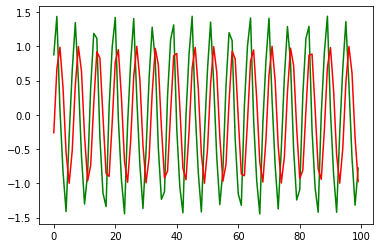

In [18]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

This was on the training data. How do we know if our model didn’t overfit? This is where the validation set, which we created earlier, comes into play:

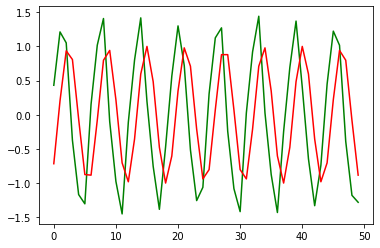

In [19]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

Not bad. The predictions are looking impressive. The RMSE score on the validation data is respectable as well:

In [20]:
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] * max_val, preds[:, 0, 0] * max_val))

NameError: name 'max_val' is not defined

### End Notes
I cannot stress enough how useful RNNs are when working with sequence data. I implore you all to take this learning and apply it on a dataset. Take a NLP problem and see if you can find a solution for it. You can always reach out to me in the comments section below if you have any questions.

In this article, we learned how to create a recurrent neural network model from scratch by using just the numpy library. You can of course use a high-level library like Keras or Caffe but it is essential to know the concept you’re implementing.

Do share your thoughts, questions and feedback regarding this article below. Happy learning!

### References
https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/